In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
from scipy.optimize import minimize, least_squares

# Load test samples
from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")

from aeons.covariance import logX_mu, logX_covinv_chol, points_at_iteration, X_mu, X_Sigma, X_Sigmainv, data_at_iteration
from aeons.true_distribution import generate_Xs
from aeons.lm_partial import analytic_lm_params
from bayes import logPr_bayes, logPr_gaussian, minimise_ls, minimise_bayes, minimise_gaussian
from likelihoods import linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()

### Try on real likelihood model

In [2]:
nk, logL = data_at_iteration(samples_g_1, 100)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
covinv_ls = np.eye(len(mean_X))

In [3]:
minimise_bayes(logL, full, mean_X, covinv_X, [1, 10, 0.1]).x

array([-1.30379911,  9.37857891,  0.10133042])

In [4]:
minimise_ls(logL, full, mean_X, [1, 10, 0.1]).x

array([-2.48426033,  9.0305156 ,  0.10273865])

### **Parameter loss function**
Compare accuracy of Bayes vs LS predictions by defining a loss function for the predicted parameters $\theta$ relative to the true parameters $\theta_0$

$$ L_2(\theta) = \sum_i (\theta_i - \theta_{0i})^2$$

Lower loss gives 'better' prediction. Eye test shows that sometimes the 'better' prediction as determined above seems to match the curve less well.

What we really want is for $\theta$ to make the target volume $X_0 = 2^{d/2} \sigma^d \Gamma(1+\frac{d}{2}) f$ as close to the true value as possible. So we should calculate and compare $X_0$ to see which $\theta$ is more accurate.


In [5]:
def L2_theta(theta_true, theta_predicted):
    frac_diffs = (theta_true - theta_predicted)/theta_true
    return np.sum(frac_diffs**2)

def target_X(theta):
    from scipy.special import gamma
    _, d, sigma = theta
    return 2**(d/2) * sigma*d * gamma(1 + d/2)

def Ltarget_theta(theta_true, theta_predicted):
    return abs(target_X(theta_true) - target_X(theta_predicted))

In [6]:
nk, logL = data_at_iteration(samples_g_1, 100)
mean_X = X_mu(nk)
covinv_X = X_Sigmainv(nk)
covinv_ls = np.eye(len(mean_X))

In [7]:
b = 0
l = 0
theta_true = np.array([1, 10, 0.1])
for i in range(20):
    Xs = generate_Xs(nk)
    y = full.func(Xs, theta_true)
    theta_b =  minimise_bayes(y, full, mean_X, covinv_X, theta_true).x
    theta_l = minimise_ls(y, full, mean_X, theta_true).x
    if Ltarget_theta(theta_true, theta_b) < Ltarget_theta(theta_true, theta_l):
        b += 1
    else:
        l += 1
    if (i % 5) == 0:
        print(f'{i}: bayes {b}, ls {l}')
print(f'{i}: bayes {b}, ls {l}')

0: bayes 0, ls 1
5: bayes 4, ls 2
10: bayes 7, ls 4
15: bayes 7, ls 9
19: bayes 8, ls 12


### **Different comparison methods**

In [8]:
Xs = generate_Xs(nk)
theta_true = np.array([1, 10, 0.1])
y = full.func(Xs, theta_true)

In [9]:
theta_b =  minimise_bayes(y, full, mean_X, covinv_X, theta_true).x
theta_l = minimise_ls(y, full, mean_X, theta_true).x
print(theta_b, theta_l)
if L2_theta(theta_true, theta_b) < L2_theta(theta_true, theta_l):
    print('L2 loss: bayes better')
else:
    print('L2 loss: ls better')

if Ltarget_theta(theta_true, theta_b) < Ltarget_theta(theta_true, theta_l):
    print('target X: bayes better')
else:
    print('target X: ls better')

[6.90785959e+01 2.69491463e+01 6.50829756e-02] [19.69552024 14.05452354  0.0851026 ]
L2 loss: ls better
target X: ls better


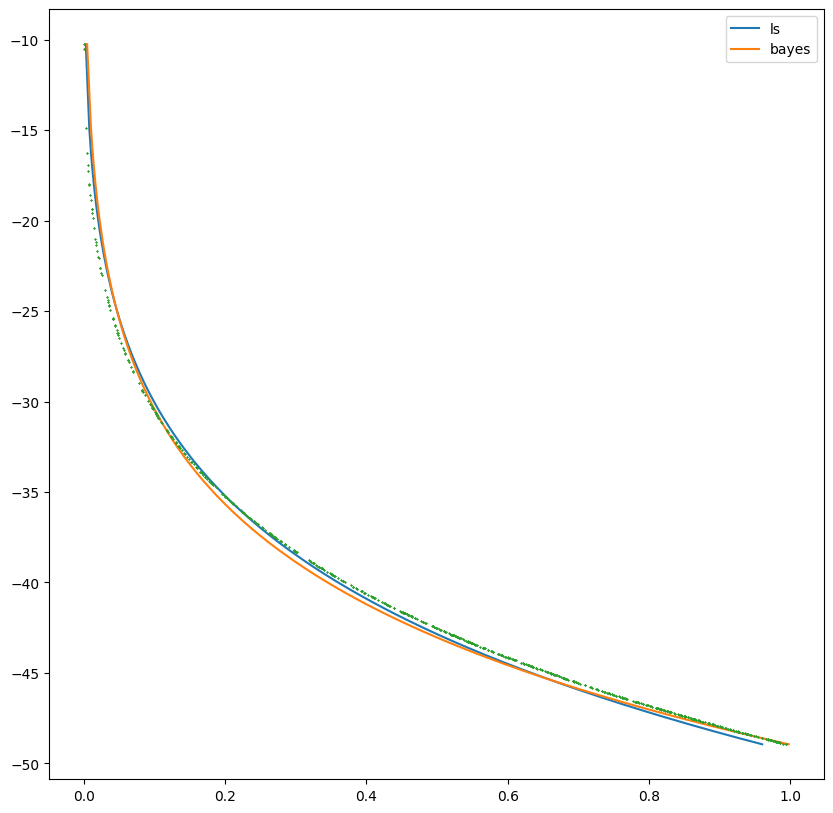

In [10]:
X_b = full.inverse(y, theta_b)
X_l = full.inverse(y, theta_l)

plt.figure(figsize=(10, 10))
plt.plot(X_l, y, label='ls')
plt.plot(X_b, y, label='bayes')
plt.plot(Xs, y, 'x', ms=1)
# plt.xlim(0.2, 0.4)
# plt.ylim(-40, -32)
plt.legend();